In [10]:
from lib.utils import * # Import custom utility functions
import gymnasium as gym
from pogema import GridConfig
from stable_baselines3 import DQN
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Set Global parameters
MAX_EPISODE_STEPS = 30
SAVE_PARAMS_PATH = 'saved/tuned_params.yml'
SAVE_METRICS_PATH = 'saved/evaluation_metrics.yml'
MODEL_NAME = 'DQN'

grid_config = GridConfig(
    size=8,                                 # size of the grid map 8 = (8x8)
    density=0.3,                            # obstacle density
    num_agents=1,                           # number of agents
    obs_radius=3,                           # defines field of view
    max_episode_steps=MAX_EPISODE_STEPS,    # time horizon
    seed=None                               # set to None for random obstacles, agents and targets positions at each reset
)

env = gym.make("Pogema-v0",grid_config=grid_config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### DQN

Sources: 

* https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html
* https://github.com/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/dqn_sb3.ipynb
* https://github.com/araffin/rl-tutorial-jnrr19/blob/sb3/1_getting_started.ipynb
* https://stable-baselines3.readthedocs.io/en/master/guide/tensorboard.html
    * https://stable-baselines3.readthedocs.io/en/master/common/logger.html#logger
    * https://www.tensorflow.org/tensorboard/get_started
    * https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml - Tuned Hyperparams for several gym envs (Hard Problem)

In [17]:
# load tuned hyperparameters into DQN model for agent training
model_params = get_model_log(MODEL_NAME, SAVE_PARAMS_PATH)
# add additional params for logging of agent training
extra_params = {
    "env":env,
    "tensorboard_log":"./tensorboard"
}
model_params.update(extra_params)
model = load_model_params(DQN, model_params)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [12]:
# Evaluate untrained agent using env
val_env = gym.make("Pogema-v0",grid_config=grid_config)

val_dqn_model = DQN(
    "MlpPolicy",
    val_env,
    verbose=1
)

mean_reward, std_reward = evaluate_policy(
    val_dqn_model,
    val_dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=MAX_EPISODE_STEPS,
)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
mean_reward: 0.00 +/- 0.00


In [19]:
# Train agent and save it
model.learn(total_timesteps=int(3.0e5), tb_log_name="dqn_baseline")
model.save("saved/dqn_baseline")

Logging to ./tensorboard/dqn_baseline_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.5     |
|    ep_rew_mean      | 0.25     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7478     |
|    time_elapsed     | 0        |
|    total_timesteps  | 102      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.6     |
|    ep_rew_mean      | 0.25     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 8469     |
|    time_elapsed     | 0        |
|    total_timesteps  | 205      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.1     |
|    ep_rew_mean      | 0.167    |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 9756     |
|    time_elapsed     | 0        |
|    total_timesteps  | 325      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.2     |
|    ep_rew_mean      | 0.188    |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes       

### Load trained agent and evaluate it

In [20]:
model = DQN.load("saved/dqn_baseline")

env.reset()
mean_reward, std_reward = evaluate_policy(model, env, deterministic=True, n_eval_episodes=20)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:0.00 +/- 0.00


In [25]:
from IPython.display import SVG, display

metrics = evaluate_metrics(model, env, num_episodes=MAX_EPISODE_STEPS, num_trials=100, verbose=False, save_animation=True)
save_metrics(metrics, MODEL_NAME, SAVE_METRICS_PATH)
print(f"Agent Success Rate: {metrics['success_rate'] * 100:.2f}%")
print(f"Steps to termination : {metrics['step_array']}")
print(f"Average steps to termination : {metrics['ave_steps']}")

Agent Success Rate: 5.00%
Steps to termination : [29, 25, 26, 10, 29]
Average steps to termination : 23.8


### Load Animation

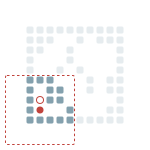

In [26]:
display(SVG('renders/render.svg'))

### Tensorboard

In [27]:
%tensorboard --logdir tensorboard/dqn_baseline_2

Launching TensorBoard...